<a href="https://colab.research.google.com/github/JnKamas/projekt_siete/blob/main/NetSci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install geodatasets
!pip install geopandas

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 51.5/51.5 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 1.1/1.1 MB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 22.9/22.9 MB 617.9 kB/s eta 0:00:00
   ---------------------------------------- 5.1/5.1 MB 520.5 kB/s eta 0:00:00
   ---------------------------------------- 1.5/1.5 MB 651.5 kB/s eta 0:00:00
   ---------------------------------------- 97.9/97.9 kB 512.9 kB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.23.1 requires importlib-metadata<7,>=1.4, but you have importlib-metadata 7.0.0 which is incompatible.
streamlit 1.23.1 requires protobuf<5,>=3.20, but you have protobuf 3.19.4 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas
from geodatasets import get_path
from shapely.geometry import LineString

In [8]:
!git clone https://github.com/JnKamas/projekt_siete.git

Cloning into 'projekt_siete'...


In [2]:
edges = pd.read_csv("projekt_siete/openflights.txt", sep=" ",header = None, names = ['source','target','weight'])

In [3]:
df = pd.read_csv("projekt_siete/openflights_airports.txt", sep=" ")
df.head()

Airport ID                        Name          City           Country  \
0           1                      Goroka        Goroka  Papua New Guinea   
1           2                      Madang        Madang  Papua New Guinea   
2           3                 Mount Hagen   Mount Hagen  Papua New Guinea   
3           4                      Nadzab        Nadzab  Papua New Guinea   
4           5  Port Moresby Jacksons Intl  Port Moresby  Papua New Guinea   

  IATA/FAA  ICAO  Latitude   Longitude  Altitude  Timezone DST  
0      GKA  AYGA -6.081689  145.391881      5282      10.0   U  
1      MAG  AYMD -5.207083  145.788700        20      10.0   U  
2      HGU  AYMH -5.826789  144.295861      5388      10.0   U  
3      LAE  AYNZ -6.569828  146.726242       239      10.0   U  
4      POM  AYPY -9.443383  147.220050       146      10.0   U

<ipython-input-4-56bba82a6483>:7: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_edges['geometry'] = gdf_edges.apply(lambda row: LineString([(gdf.loc[row['source'], 'geometry'].x, gdf.loc[row['source'], 'geometry'].y),


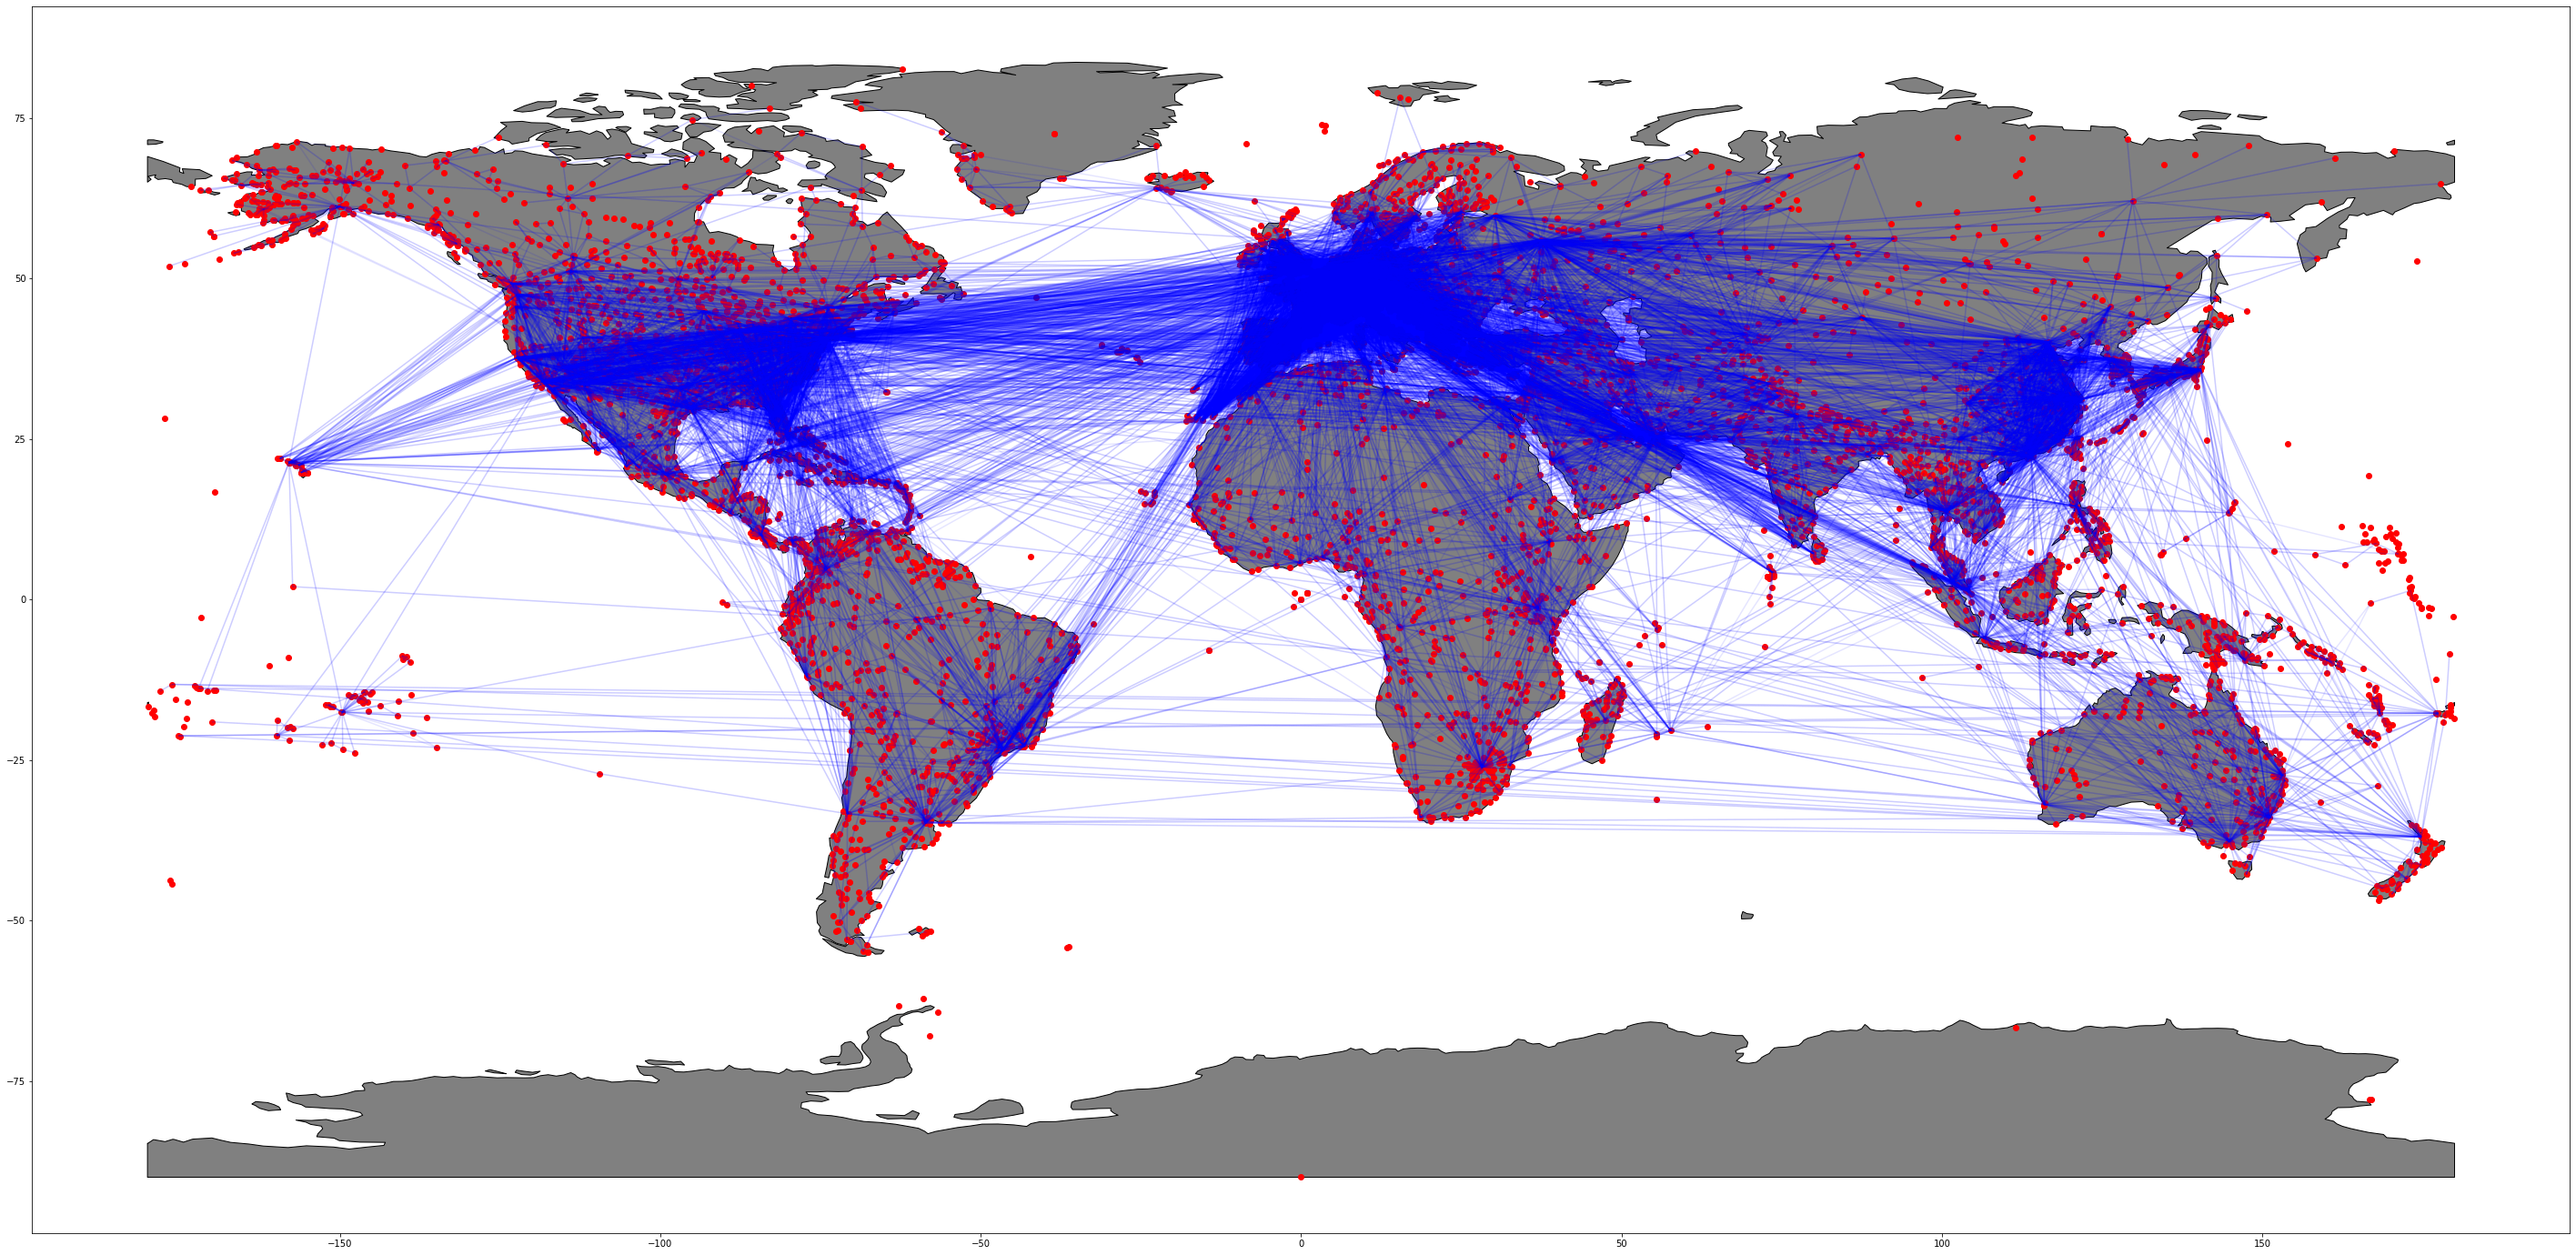

In [4]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
world = geopandas.read_file(get_path("naturalearth.land"))

#edges
gdf_edges = geopandas.GeoDataFrame(edges)
gdf = gdf.set_index('Airport ID')
gdf_edges['geometry'] = gdf_edges.apply(lambda row: LineString([(gdf.loc[row['source'], 'geometry'].x, gdf.loc[row['source'], 'geometry'].y),
                                                               (gdf.loc[row['target'], 'geometry'].x, gdf.loc[row['target'], 'geometry'].y)]),
                                       axis=1)
gdf = gdf.reset_index()
gdf_edges.crs = gdf.crs

ax = world.plot(color="grey", edgecolor="black", figsize = (50,500))

gdf_edges.plot(ax = ax, color = 'blue', alpha = 0.1)
gdf.plot(ax=ax, color="red")

plt.show()

**Základné štatistiky**
ako rozdelenie stupňa vrchola, hustota hrán centralita, blízkosť

*   rozdelenie stupňa vrchola
*   hustota hrán
*   blízkosť



In [5]:
G = nx.from_pandas_edgelist(edges, 'source', 'target',['weight'],create_using = nx.DiGraph())
verticesNotIncludedInEdgeList = np.setdiff1d( df['Airport ID'], np.union1d(edges['source'],edges['target']))
G.add_nodes_from(verticesNotIncludedInEdgeList)

In [6]:
# Adjacency matrix nie je symeytricka
adj_mat = nx.adjacency_matrix(G)
(adj_mat.T != adj_mat).sum()

2630

In [7]:
gdf = gdf.sort_values(by = 'Airport ID')
gdf['in_degree'] = list(dict(sorted(dict(G.in_degree()).items())).values())
gdf['out_degree'] = list(dict(sorted(dict(G.out_degree()).items())).values())
gdf['degree'] = gdf['out_degree'] + gdf['in_degree']

Text(0.5, 0.98, 'Degree distribution for all vertices')

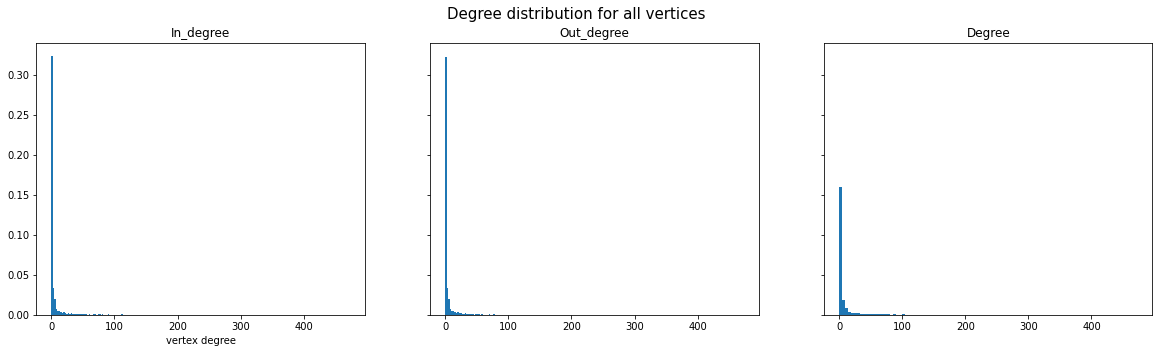

In [8]:
fig,ax = plt.subplots(1,3,figsize = (20,5), sharex = True, sharey = True)
graph_in = ax[0].hist(gdf['in_degree'] , 100, density = 1)
graph_out = ax[1].hist(gdf['out_degree'] , 100, density = 1)
graph = ax[2].hist(gdf['degree'] , 100, density = 1)

ax[0].set_title('In_degree')
ax[1].set_title('Out_degree')
ax[2].set_title('Degree')

ax[0].set_xlabel('vertex degree')
fig.suptitle('Degree distribution for all vertices',fontsize = 15)

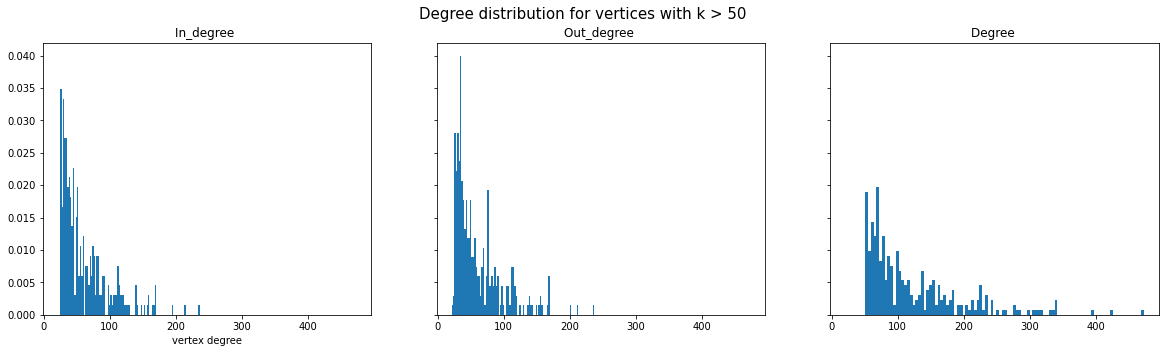

In [9]:
fig,ax = plt.subplots(1,3,figsize = (20,5), sharex = True, sharey = True)
high_degrees = gdf[gdf['degree'] > 50]
graph_in = ax[0].hist(high_degrees['in_degree'] , 100, density = 1)
graph_out = ax[1].hist(high_degrees['out_degree'] , 100, density = 1)
graph = ax[2].hist(high_degrees['degree'] , 100, density = 1)

ax[0].set_title('In_degree ')
ax[1].set_title('Out_degree ')
ax[2].set_title('Degree ')

ax[0].set_xlabel('vertex degree')
fig.suptitle('Degree distribution for vertices with k > 50',fontsize = 15)
plt.show()

In [10]:
# 5 vertices with highest degree
gdf.sort_values(by = 'degree', ascending = False).head()

Airport ID               Name       City         Country IATA/FAA  ICAO  \
337          340     Frankfurt Main  Frankfurt         Germany      FRA  EDDF   
1358        1382  Charles De Gaulle      Paris          France      CDG  LFPG   
575          580           Schiphol  Amsterdam     Netherlands      AMS  EHAM   
3268        3364       Capital Intl    Beijing           China      PEK  ZBAA   
498          502            Gatwick     London  United Kingdom      LGW  EGKK   

       Latitude   Longitude  Altitude  Timezone DST  \
337   50.026421    8.543125       364       1.0   E   
1358  49.012779    2.550000       392       1.0   E   
575   52.308613    4.763889       -11       1.0   E   
3268  40.080111  116.584556       116       8.0   U   
498   51.148056   -0.190278       202       0.0   E   

                        geometry  in_degree  out_degree  degree  
337     POINT (8.54312 50.02642)        236         237     473  
1358    POINT (2.55000 49.01278)        213         213     426  
575     POINT (4.76389 52.30861)        194         201     395  
3268  POINT (116.58456 40.08011)        170         170     340  
498    POINT (-0.19028 51.14806)        169         170     339

**Betweenes centrality**

Ktoré letiská sú najvyťaženejšie (v zmysle prestupov)?

**Closeness centrality**

Ktoré letiská sú najvýhodnejšie v zmysle, že sa viem od tiaľ dostať do veľa miest s málo prestupmi?

In [11]:
b_centrality = nx.betweenness_centrality(G)

In [12]:
c_centrality = nx.closeness_centrality(G)

In [13]:
gdf = gdf.sort_values(by = 'Airport ID')
gdf['betweeness_centrality'] = list(dict(sorted(b_centrality.items())).values())
gdf['closeness_centrality'] = list(dict(sorted(c_centrality.items())).values())

gdf[['Airport ID', 'City','degree','betweeness_centrality', 'closeness_centrality']].sort_values(by = 'closeness_centrality', ascending = False)

Airport ID       City  degree  betweeness_centrality  \
337          340  Frankfurt     473               0.013632   
1358        1382      Paris     426               0.013414   
503          507     London     315               0.008533   
575          580  Amsterdam     395               0.007948   
2137        2188      Dubai     331               0.010452   
...          ...        ...     ...                    ...   
2854        2931      Pevek       0               0.000000   
2872        2950      Gomel       0               0.000000   
2873        2951    Vitebsk       0               0.000000   
2875        2953      Minsk       0               0.000000   
6629        8056  Hudson NY       0               0.000000   

      closeness_centrality  
337               0.174701  
1358              0.171926  
503               0.171363  
575               0.168760  
2137              0.166699  
...                    ...  
2854              0.000000  
2872              0.000000  
2873              0.000000  
2875              0.000000  
6629              0.000000  

[6630 rows x 5 columns]

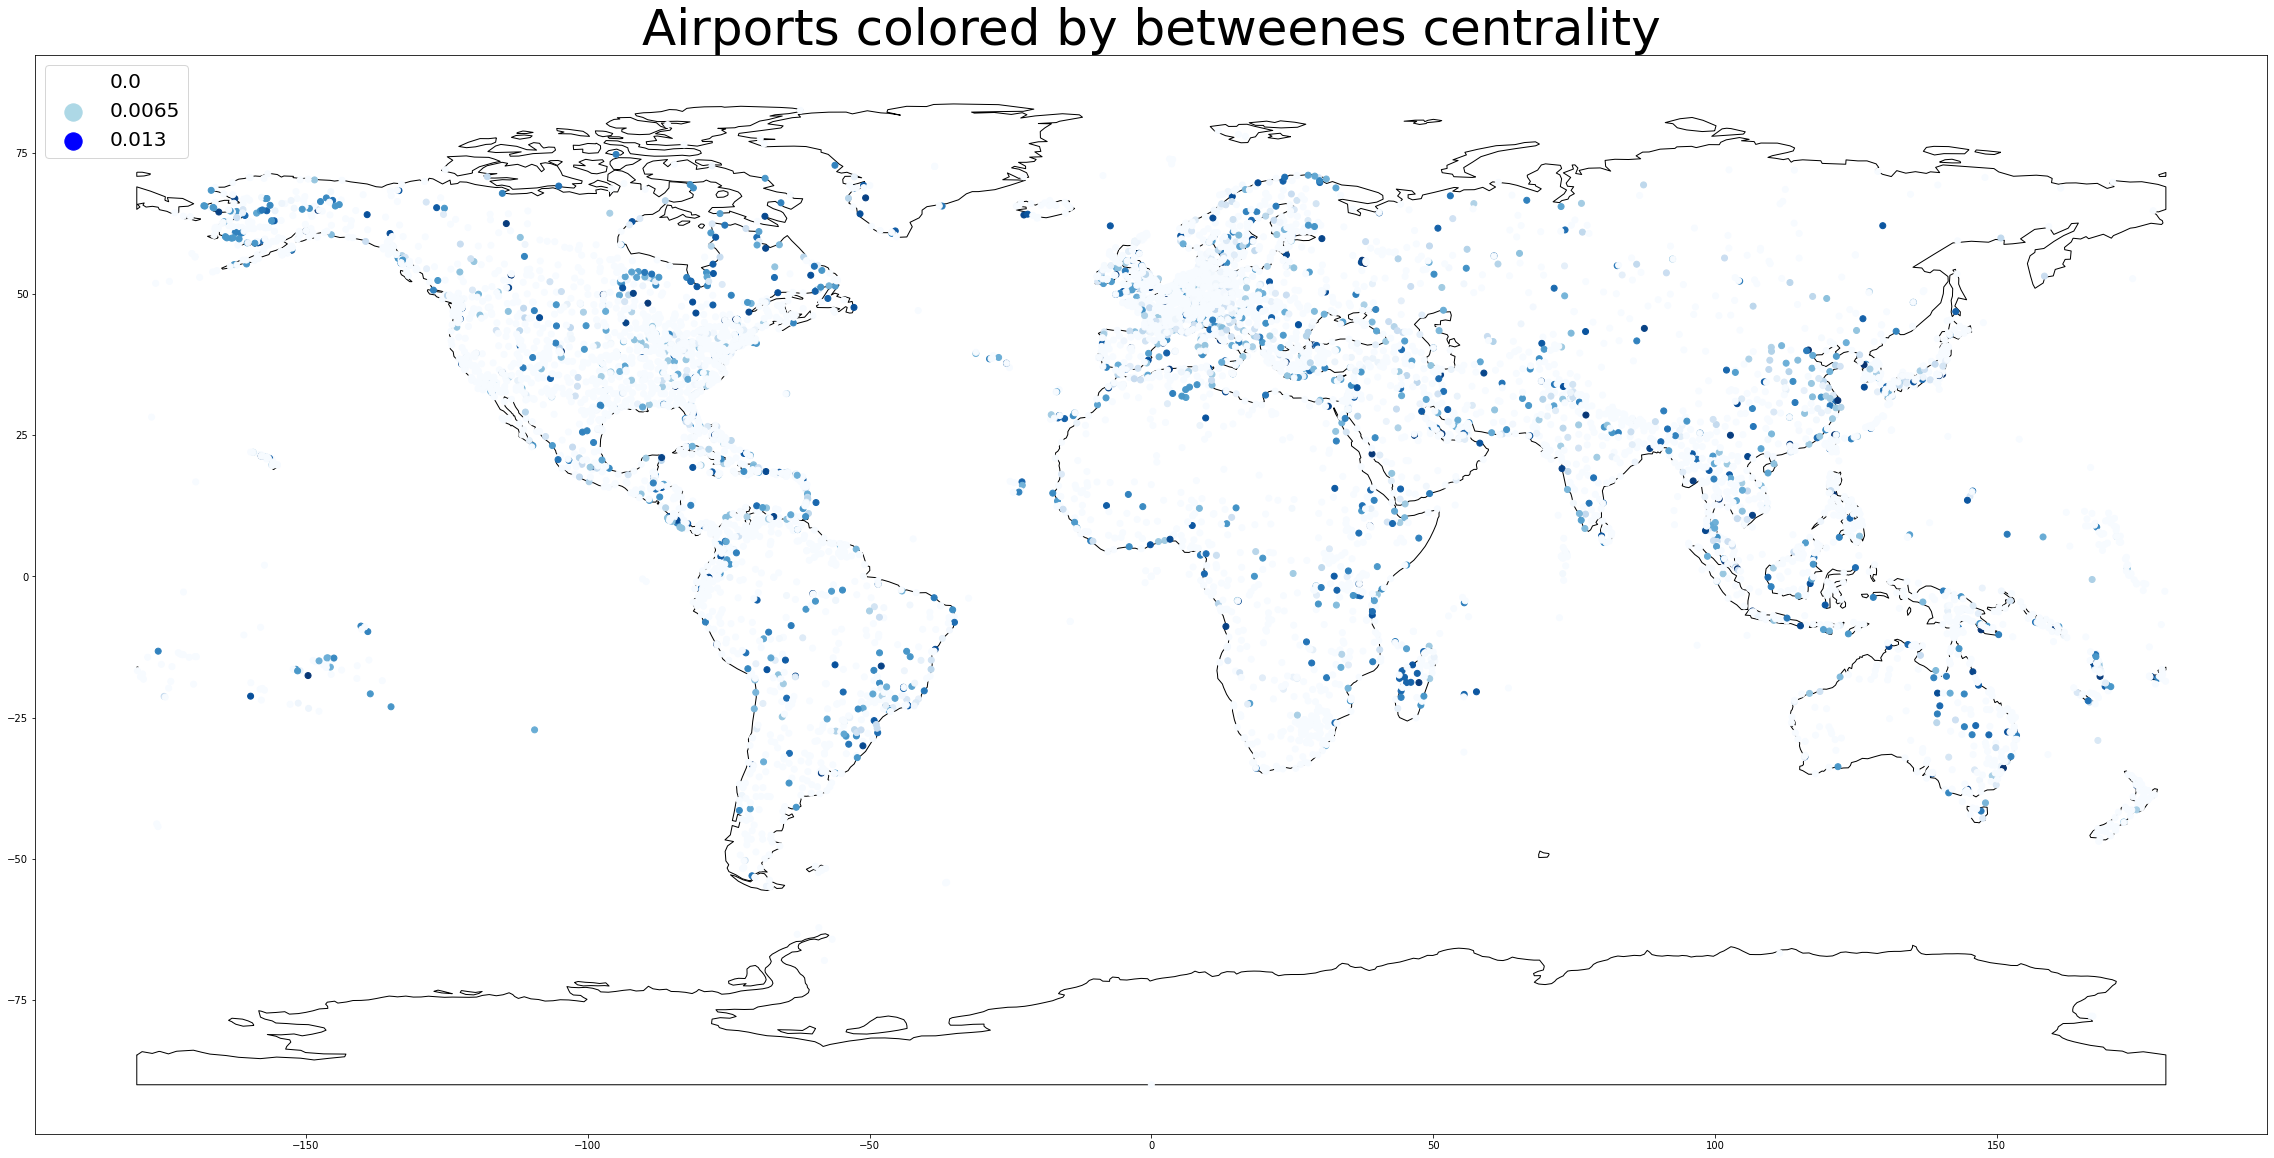

In [14]:
ax = world.plot(color="white", edgecolor="black", figsize = (40,100))
gdf.plot(ax=ax, column = 'betweeness_centrality', legend = False, categorical=True, cmap = 'Blues')
ax.set_title('Airports colored by betweenes centrality', fontsize = 50)

custom_legend = [
    ('0.0', 'white'),
    ('0.0065', 'lightblue'),
    ('0.013', 'blue')
]

for label, color in custom_legend:
    ax.scatter([], [], color=color, label=label, s = 300)
legend = ax.legend(loc = 'upper left', fontsize=20)

plt.show()

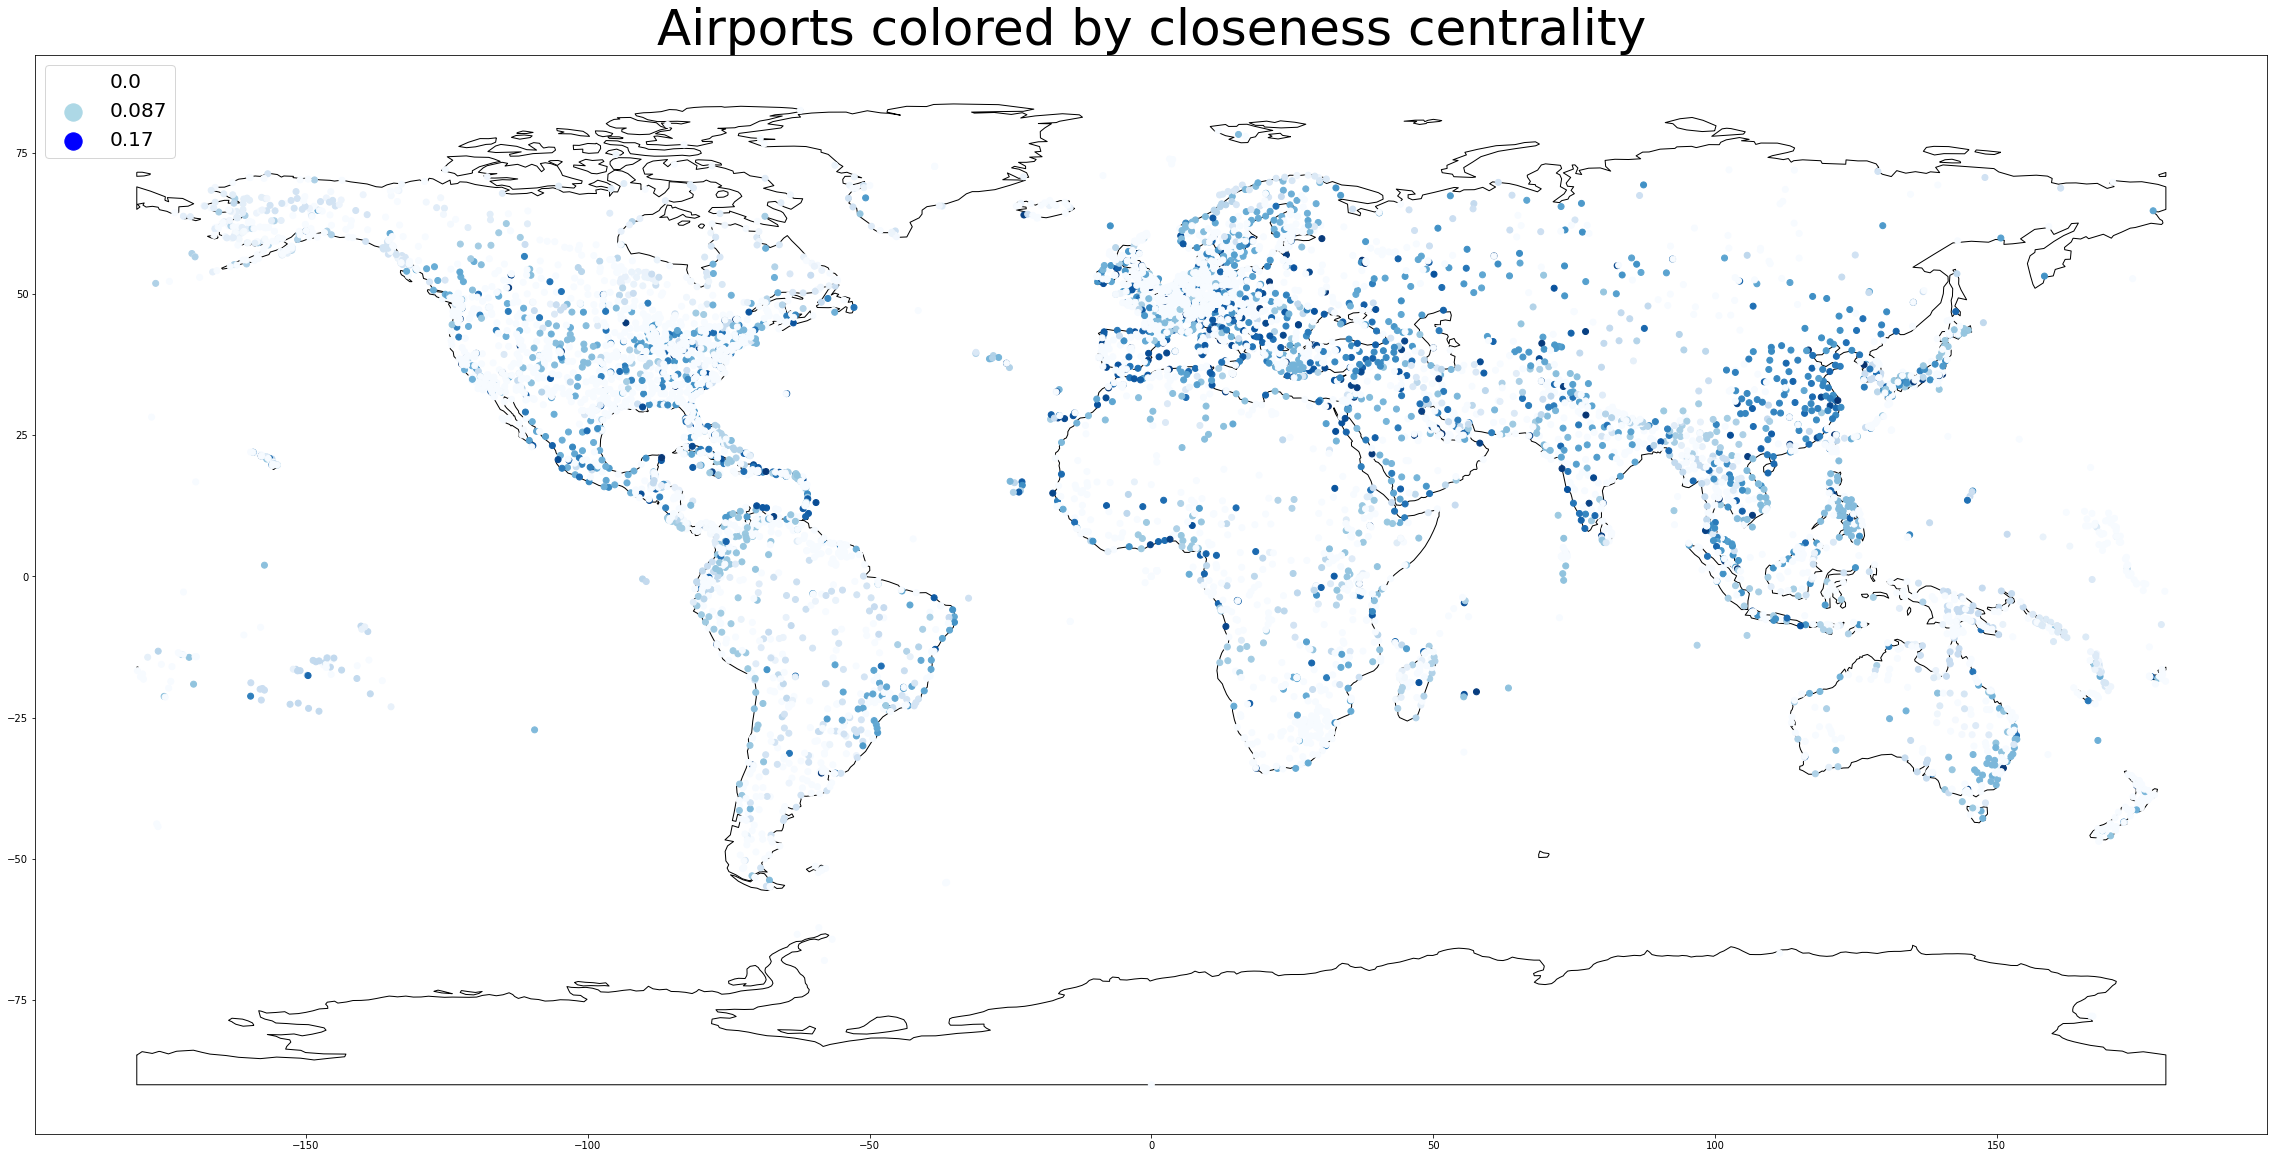

In [15]:
ax = world.plot(color="white", edgecolor="black", figsize = (40,100))
gdf.plot(ax=ax, column = 'closeness_centrality', legend = False, categorical=True, cmap = 'Blues')
ax.set_title('Airports colored by closeness centrality', fontsize = 50)

custom_legend = [
    ('0.0', 'white'),
    ('0.087', 'lightblue'),
    ('0.17', 'blue')
]

for label, color in custom_legend:
    ax.scatter([], [], color=color, label=label, s = 300)
legend = ax.legend(loc = 'upper left', fontsize=20)

plt.show()

**Zhlukový koeficient a modularita siete**

Zabezpečenie priameho letu tam aj naspäť
-trojuholníky, dvojuholníky

In [16]:
local_clustering_coefs = nx.clustering(G)
gdf['local_clustering_coef'] = dict(sorted(local_clustering_coefs.items())).values()
gdf.sort_values(by = 'local_clustering_coef', ascending = False)[['Name','Country','local_clustering_coef']][0:10]

Name         Country  local_clustering_coef
504            Southend  United Kingdom                    1.0
1876     Orestes Acosta            Cuba                    1.0
3821         Selaparang       Indonesia                    1.0
1905  Governors Harbour         Bahamas                    1.0
1904    North Eleuthera         Bahamas                    1.0
4328    Kushiro Airport           Japan                    1.0
3023                Leh           India                    1.0
1897       Treasure Cay         Bahamas                    1.0
1895       Spring Point         Bahamas                    1.0
3810       Tjilik Riwut       Indonesia                    1.0

In [17]:
avg_clustrering = np.mean(list(local_clustering_coefs.values()))
avg_clustrering

0.19416011385029147

In [18]:
transitivity = nx.transitivity(G)
reciprocity = nx.reciprocity(G)

print(transitivity)
print(reciprocity)

0.25365017708214327
0.9720337038129897


# Silno suvisle komponenty

In [38]:
scc = sorted(list(nx.strongly_connected_components(G)), key=len)

print("Strongly Connected Components:", len(scc))
print("Maximum size of component: ", max([len(x) for x in scc]))

Strongly Connected Components: 3743
Maximum size of component:  2868


In [39]:
sizes_of_sccs = [len(x) for x in scc]
sizes_of_sccs.sort()
        
print("The number of one vertex components is:", sizes_of_sccs.count(1))
print(f"The largest component includes {max(sizes_of_sccs) / sum(sizes_of_sccs) * 100:0.2f}% of vertices")

The number of one vertex components is: 3734
The largest component includes 43.26% of vertices


In [44]:
node_to_scc = {}
for i, component in enumerate(scc, 1):
    for node in component:
        node_to_scc[node] = i

# Add SCC ID column to DataFrame
gdf['SCC_ID'] = gdf['Airport ID'].map(node_to_scc)
gdf.loc[gdf['SCC_ID'] == 3742]

Airport ID                  Name    City        Country IATA/FAA  ICAO  \
1957        1998                  Kone    Kone  New Caledonia      KNQ  NWWD   
1959        2000                 Lifou   Lifou  New Caledonia      LIF  NWWL   
1960        2001               Magenta  Noumea  New Caledonia      GEA  NWWM   
1961        2002                  Mare    Mare  New Caledonia      MEE  NWWR   
1963        2004                 Ouvea   Ouvea  New Caledonia      UVE  NWWV   
4403        5919          Tiga Airport    Tiga  New Caledonia      TGJ  NWWA   
4401        5921  Île des Pins Airport     NaN  New Caledonia      ILP  NWWE   

       Latitude   Longitude  Altitude  Timezone DST  \
1957 -21.053428  164.837806        23      11.0   U   
1959 -20.774800  167.239864        92      11.0   U   
1960 -22.258278  166.472806        10      11.0   U   
1961 -21.481678  168.037508       141      11.0   U   
1963 -20.640556  166.572778        23      11.0   U   
4403 -21.096100  167.804000       128      11.0   U   
4401 -22.588900  167.456000       315      11.0   U   

                         geometry  in_degree  out_degree  degree  \
1957  POINT (164.83781 -21.05343)          1           1       2   
1959  POINT (167.23986 -20.77480)          2           2       4   
1960  POINT (166.47281 -22.25828)          7           6      13   
1961  POINT (168.03751 -21.48168)          1           1       2   
1963  POINT (166.57278 -20.64056)          1           1       2   
4403  POINT (167.80400 -21.09610)          2           2       4   
4401  POINT (167.45600 -22.58890)          1           1       2   

      betweeness_centrality  closeness_centrality  local_clustering_coef  \
1957           0.000000e+00              0.000603               0.000000   
1959           0.000000e+00              0.000644               1.000000   
1960           9.103942e-07              0.001073               0.055556   
1961           0.000000e+00              0.000603               0.000000   
1963           0.000000e+00              0.000603               0.000000   
4403           0.000000e+00              0.000644               1.000000   
4401           0.000000e+00              0.000603               0.000000   

      SCC_ID  
1957    3742  
1959    3742  
1960    3742  
1961    3742  
1963    3742  
4403    3742  
4401    3742

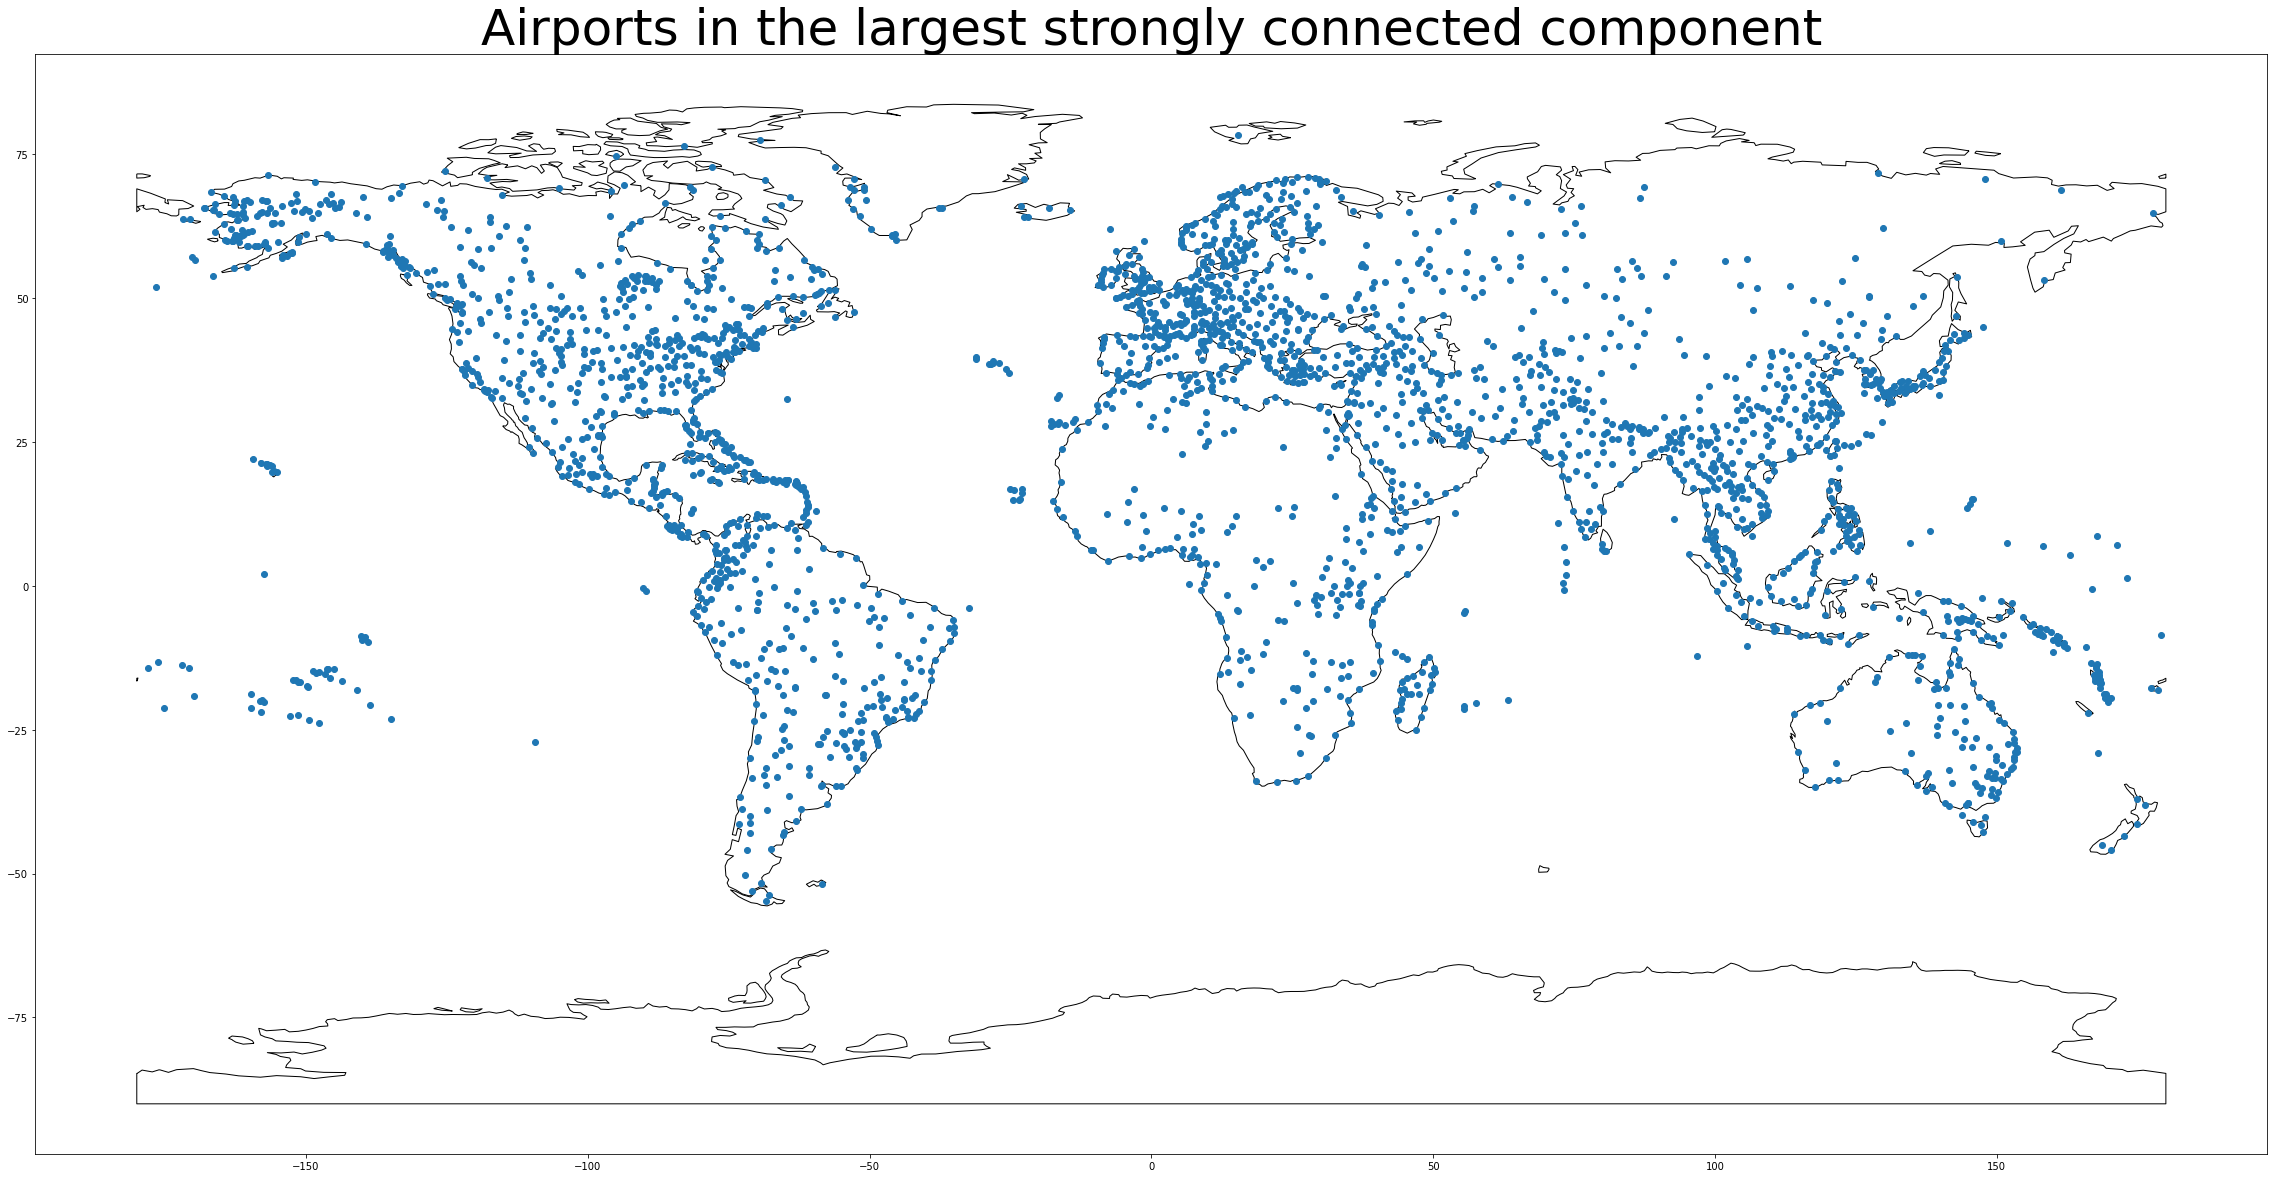

In [48]:
# The largest component
ax = world.plot(color="white", edgecolor="black", figsize = (40,100))
gdf.loc[gdf["SCC_ID"] == 3743].plot(ax=ax)
ax.set_title('Airports in the largest strongly connected component', fontsize = 50)

plt.show()

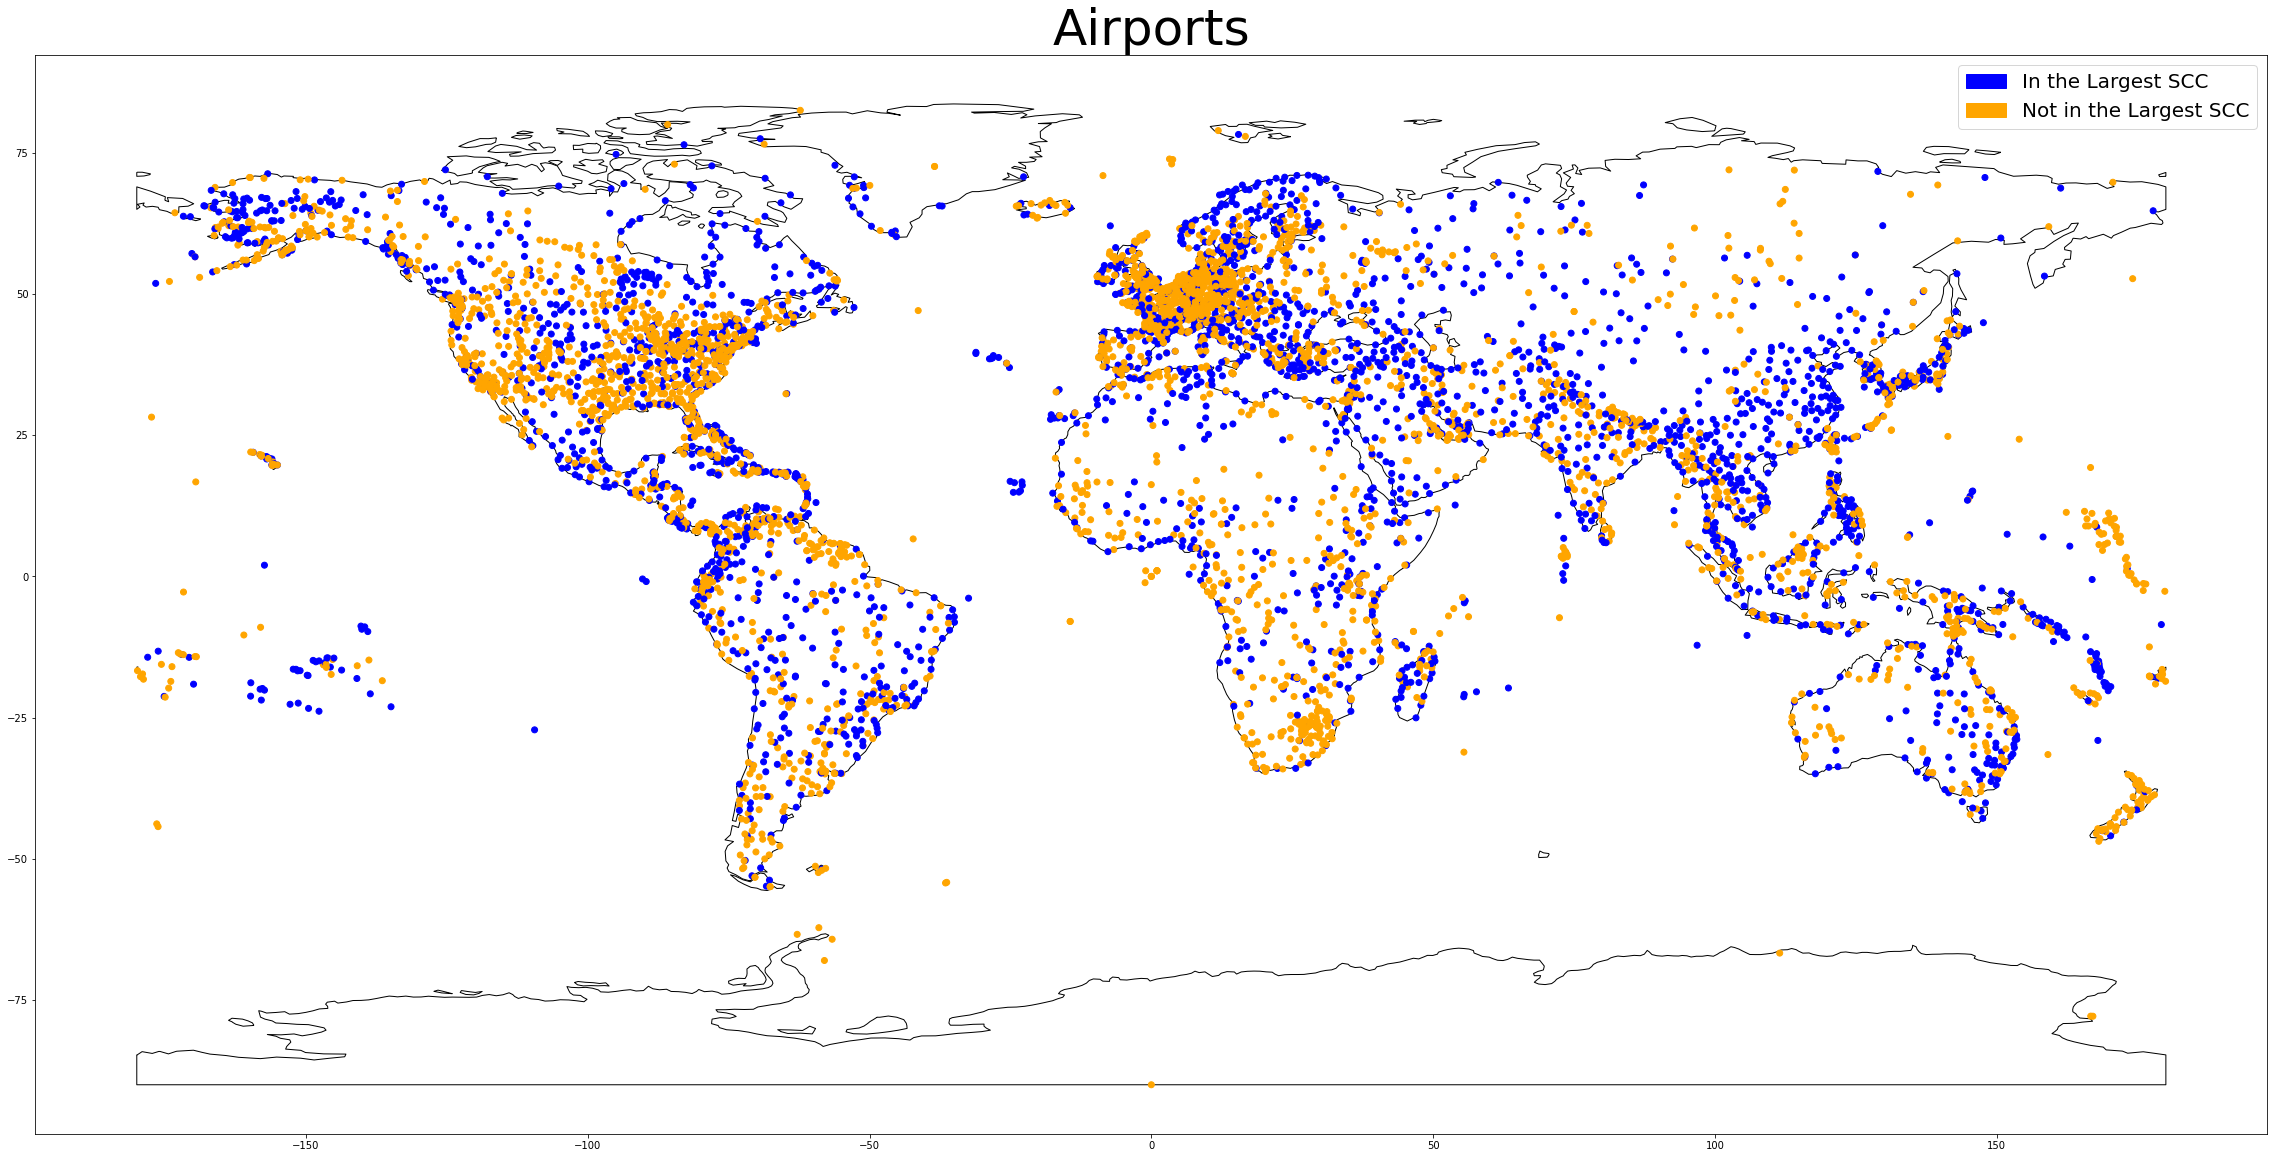

In [51]:
import matplotlib.patches as mpatches
# Create a new column to store the colors
gdf['color'] = 'orange'  # Initialize all vertices to be orange
gdf.loc[gdf['SCC_ID'] == 3743, 'color'] = 'blue'  # Set vertices with SCC_ID 3743 to blue

# Plot the graph
ax = world.plot(color="white", edgecolor="black", figsize=(40, 100))
gdf.plot(ax=ax, color=gdf['color'])
ax.set_title('Airports', fontsize=50)

legend_handles = [mpatches.Patch(color='blue', label='In the Largest SCC'),
                  mpatches.Patch(color='orange', label='Not in the Largest SCC')]
ax.legend(handles=legend_handles, fontsize=20)

# Show the plot
plt.show()